In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.mlp import MLP
from models.resnet import ResNetVAE
from models.autoencoders import VAE
from trainers.standard import train_fm_conditional
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 32
DATAPOINT_COUNT = 200
# AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
# AE_PATH = "./logs/models/resnet_2024-11-06_10:54/pth/epoch_700.pth" # 32x32
AE_PATH = "./logs/models/resnet_2024-11-07_14:07/pth/epoch_700.pth" # 256x256
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [3]:
# Create the input data: latent representation of initial scene images
X = []
for i, im_path in tqdm(enumerate(im_paths)):
    if i == DATAPOINT_COUNT: break
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    X.append(image)

X = np.array(X)
print(X.shape)

200it [00:00, 772.71it/s]


(200, 3, 256, 256)


In [4]:
# Create output data: waypoint collections from the paths
ways = []
for i, ep_path in tqdm(enumerate(dirs)):
    if i == DATAPOINT_COUNT: break
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

200it [00:07, 27.72it/s]

(200, 9)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [8]:
encoder = ResNetVAE(latent_dim=LATENT_DIM).to(device=device)
# encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

In [9]:
input_size = LATENT_DIM + X_train.shape[1] + 1
mlp_model = MLP(input_size, y_train.shape[1], hidden_layers=[256, 128]).to(device)
# mlp_model, encoder = train_with_encoder(mlp_model, encoder, device, train_loader, val_loader, n_epochs=1000, lr=1e-4)
mlp_model, encoder = train_fm_conditional(mlp_model, encoder, device, train_loader, val_loader, n_epochs=1000, lr=1e-4)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 256, 256] to have 1 channels, but got 3 channels instead

In [ ]:
for i in range(2):
    if i:
        latent_images, _ = encoder.encode(torch.Tensor(X_test).to(device))
        y_pred = mlp_model(latent_images).cpu().detach().numpy()
        errors = y_test - y_pred
    else:
        latent_images, _ = encoder.encode(torch.Tensor(X_train).to(device))
        y_pred = mlp_model(latent_images).cpu().detach().numpy()
        errors = y_train - y_pred
    
    errors = errors[:, :2]
    errors = [np.linalg.norm(e) for e in errors]
    mean_error = sum(errors)/len(errors)
    devs = [abs(e-mean_error) for e in errors]
    dev_error = sum(devs)/len(devs)

    max_error = .025
    total_wins = 0
    for e in errors:
        if e < max_error:
            total_wins += 1

    if i:
        print("Test avg. dist. from desired point (m): ", mean_error)
        print("Test avg. dev. from desired point (m): ", dev_error)
        print(f"Success rate: {(total_wins/len(errors)*100):.2f}%")
    else:
        print("Train avg. dist. from desired point (m): ", mean_error)
        print("Train avg. dev. from desired point (m): ", dev_error)
    print("+--------------------------------------------------------------+")

Train avg. dist. from desired point (m):  0.13215438261768797
Train avg. dev. from desired point (m):  0.04490365239393903
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.13670327368078988
Test avg. dev. from desired point (m):  0.04176879575593743
Success rate: 2.50%
+--------------------------------------------------------------+


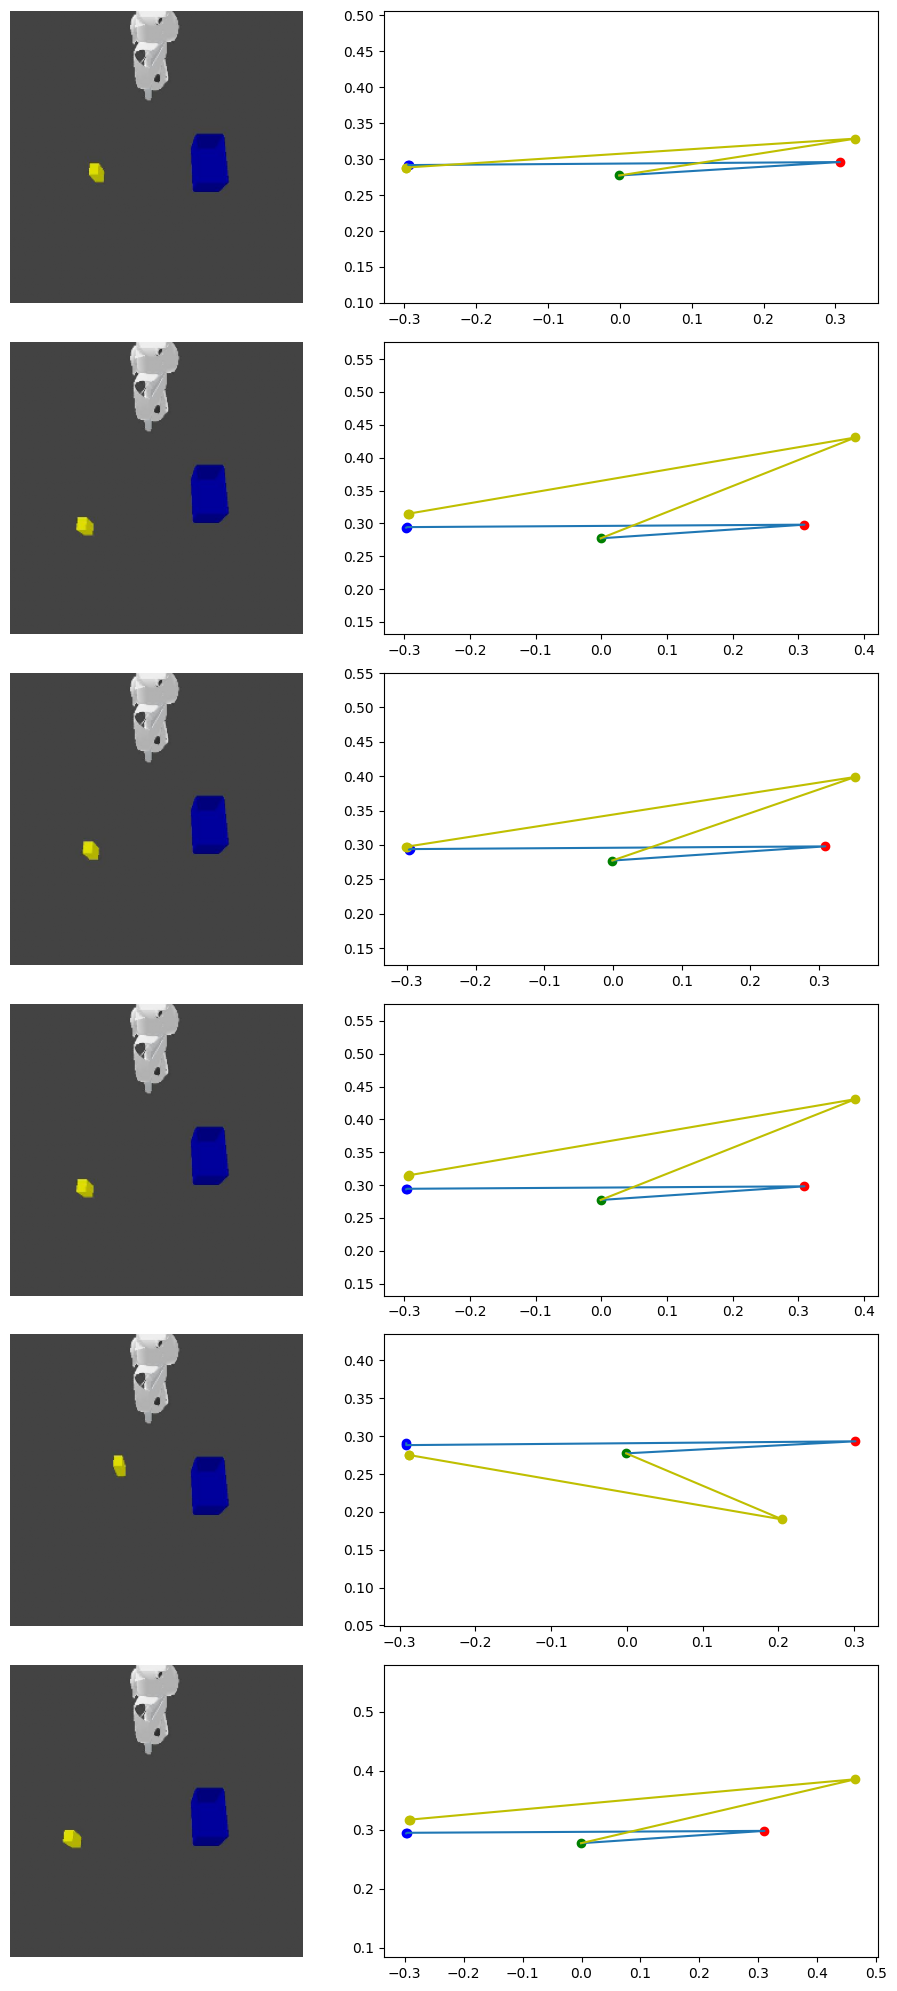

In [ ]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

imgs = X_test[rand_indices]

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

latent_images, _ = encoder.encode(torch.Tensor(imgs).to(device))
imgs = np.transpose(imgs, (0, 2, 3, 1))
pred_waypoints = mlp_model(latent_images).cpu().detach().numpy()
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)

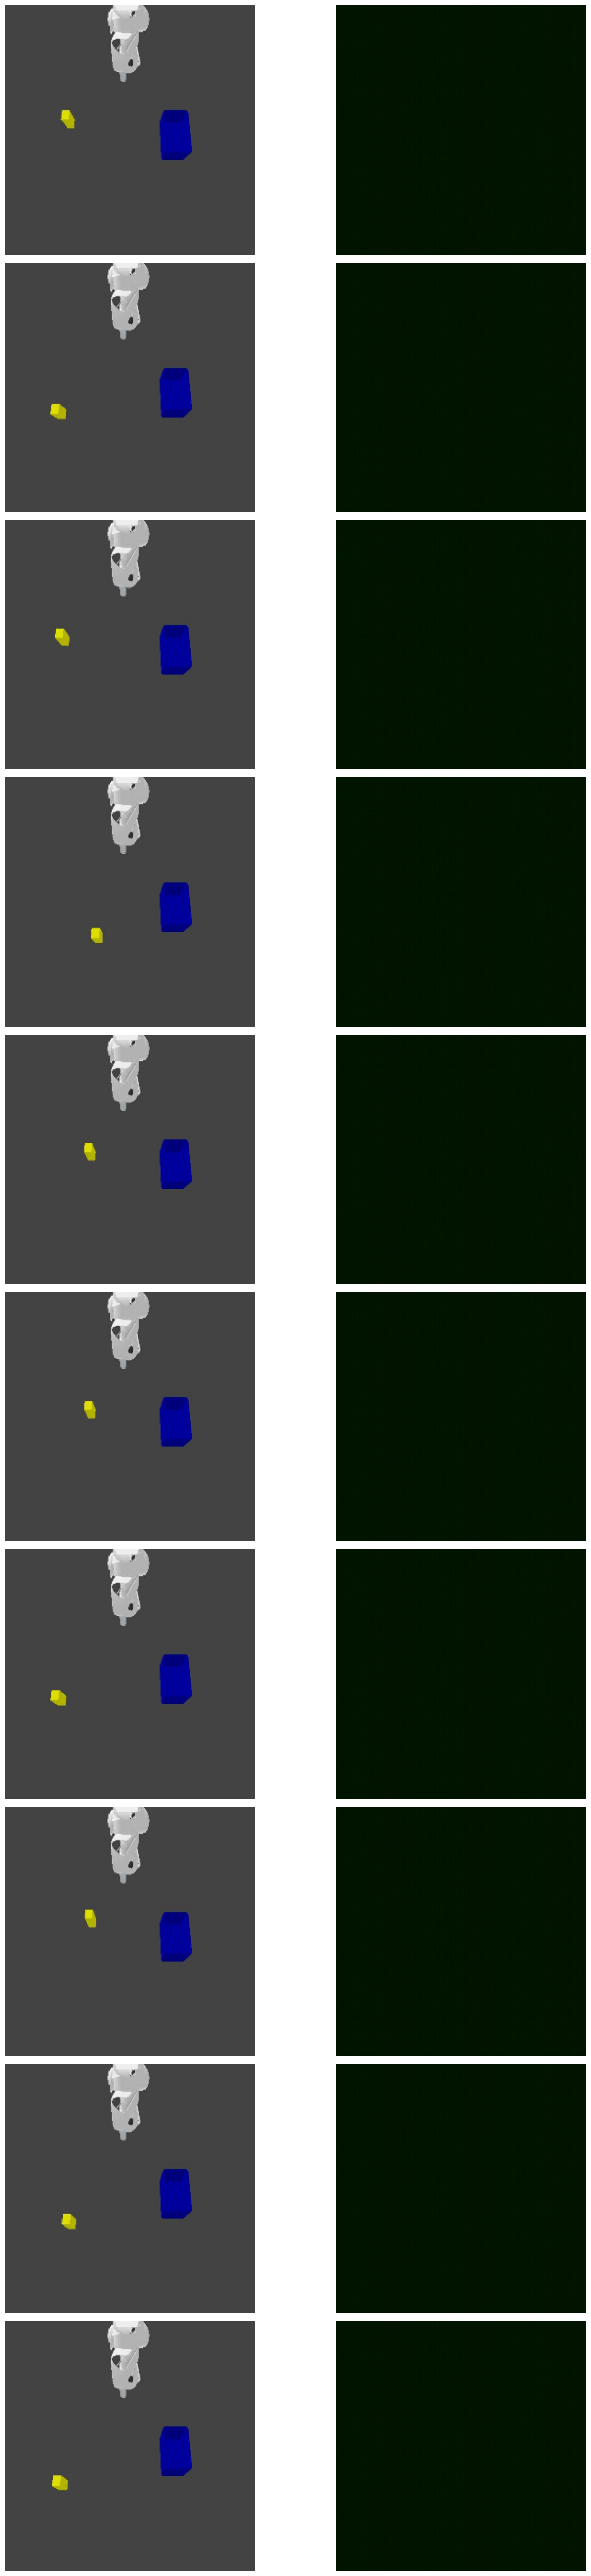

In [ ]:
example_count = 10
rand_images = np.array([val_dataset[np.random.randint(0, len(val_dataset))][0] for _ in range(example_count)])
pred_images = encoder.forward_clean(torch.Tensor(rand_images).to(device))

fig, axes = plt.subplots(example_count, 2, figsize=(15, 50))

for i in range(example_count):
    image = np.transpose(rand_images[i], (1, 2, 0))
    axes[i, 0].imshow(image)
    axes[i, 1].imshow(pred_images[i])

    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()